In [19]:
import warnings

import pandas as pd
import numpy as np
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, recall_score, confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import matplotlib.pyplot as plt

from shap import TreeExplainer

warnings.filterwarnings('ignore')

In [20]:
def individual_log_loss(y_true, y_pred, eps=1e-15):
    """Compute log-loss for each individual of the sample."""

    y_pred = np.clip(y_pred, eps, 1 - eps)
    return - y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)


def shap_sum2proba(shap_sum):
    """Compute sigmoid function of the Shap sum to get predicted probability."""

    return 1 / (1 + np.exp(-shap_sum))


def get_preds_shaps(X_train, X_val, y_train, y_val, is_train=True):
    """Get predictions (predicted probabilities) and SHAP values for a dataset."""
    space = {
        'colsample_bytree': 0.8694668068945633,
        'gamma': 3.8273847579638383,
        'learning_rate': 0.24623006595084537,
        'max_depth': 7,
        'min_child_weight': 3.5682287335539407,
        'reg_alpha': 2.338903756626607,
        'reg_lambda': 8.134971922940249,
        'subsample': 0.5003470732993074
    }
    f1, model = evaluate_model_opt(X_train, X_val, y_train, y_val, space)

    X = None
    y = None

    if is_train == True:
        X = X_train.copy()
    else:
        X = X_val.copy()

    preds = pd.Series(model.predict_proba(X)[:, 1], index=X.index)
    shap_explainer = TreeExplainer(model)

    shap_values = shap_explainer.shap_values(X)
    shap_expected_value = shap_explainer.expected_value

    shaps = pd.DataFrame(
        data=shap_values,
        index=X.index,
        columns=X.columns)
    return preds, shaps, shap_expected_value


def get_feature_contributions(y_true, y_pred, shap_values, shap_expected_value):
    """Compute prediction contribution and error contribution for each feature."""

    prediction_contribution = shap_values.abs().mean().rename("prediction_contribution")

    ind_log_loss = individual_log_loss(y_true=y_true['result_match'], y_pred=y_pred).rename("log_loss")
    y_pred_wo_feature = shap_values.apply(lambda feature: shap_expected_value + shap_values.sum(axis=1) - feature).applymap(shap_sum2proba)
    ind_log_loss_wo_feature = y_pred_wo_feature.apply(lambda feature: individual_log_loss(y_true=y_true['result_match'], y_pred=feature))
    ind_log_loss_diff = ind_log_loss_wo_feature.apply(lambda feature: ind_log_loss - feature)
    error_contribution = ind_log_loss_diff.mean().rename("error_contribution").T

    return prediction_contribution, error_contribution

In [21]:
def evaluate_model_opt(X_train, X_val, y_train, y_val, space):
    model = XGBClassifier(**space, random_state=42, enable_categorical=True, scale_pos_weight=2)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0, early_stopping_rounds=25)

    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred)

    y_pred = model.predict(X_val)

    return f1_score(y_val, y_pred), model

In [22]:
X = pd.read_csv('../data/new_features/df_.csv')
y = pd.read_csv('../data/new_features/y.csv')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
space = {
    'colsample_bytree': 0.8694668068945633,
    'gamma': 3.8273847579638383,
    'learning_rate': 0.24623006595084537,
    'max_depth': 7,
    'min_child_weight': 3.5682287335539407,
    'reg_alpha': 2.338903756626607,
    'reg_lambda': 8.134971922940249,
    'subsample': 0.5003470732993074
}

f1, xgb_model = evaluate_model_opt(X_train, X_val, y_train, y_val, space)

f1

0.6619318181818182

In [24]:
from shap import TreeExplainer

shap_explainer = TreeExplainer(xgb_model)
shap_values = shap_explainer.shap_values(X_train)

In [25]:
preds_train, shaps_train, shap_expected_value_train = get_preds_shaps(X_train, X_val, y_train, y_val, True)
preds_val, shaps_val, shap_expected_value_val = get_preds_shaps(X_train, X_val, y_train, y_val, False)

In [26]:
# assert ((preds_train - (shap_expected_value_train + shaps_train.sum(axis=1)).apply(shap_sum2proba)).abs() < 1e-10).all()
# assert ((preds_val - (shap_expected_value_val + shaps_val.sum(axis=1)).apply(shap_sum2proba)).abs() < 1e-10).all()

In [27]:
prediction_contribution_trn, error_contribution_trn = get_feature_contributions(
    y_true=y_train,
    y_pred=preds_train,
    shap_values=shaps_train,
    shap_expected_value=shap_expected_value_train
)

prediction_contribution_val, error_contribution_val = get_feature_contributions(
    y_true=y_val,
    y_pred=preds_val,
    shap_values=shaps_val,
    shap_expected_value=shap_expected_value_val
)

contributions_trn = pd.concat([prediction_contribution_trn, error_contribution_trn], axis=1)
contributions_val = pd.concat([prediction_contribution_val, error_contribution_val], axis=1)

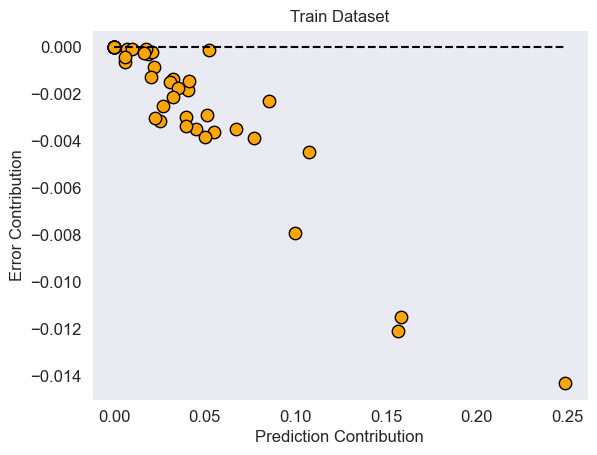

In [28]:
fig, ax = plt.subplots()

ax.scatter(contributions_trn["prediction_contribution"], contributions_trn["error_contribution"], s=80, color="orange", edgecolors="black")
ax.hlines(y=0, xmin=0, xmax=contributions_trn["prediction_contribution"].max(), ls="--", color="black")
ax.tick_params(axis="both", which="major", labelsize=12)
ax.grid();
ax.set_axisbelow(True)
ax.set_title("Train Dataset", fontsize=12)
ax.set_xlabel("Prediction Contribution", fontsize=12)
ax.set_ylabel("Error Contribution", fontsize=12)

fig.savefig("single_trn.png", dpi=200, bbox_inches="tight")

In [29]:
pd.set_option("display.max_rows", 10)
contributions_trn.sort_values("prediction_contribution", ascending=False).head(10)

,prediction_contribution,error_contribution
avg_home_team_rating,0.248893,-0.014315
avg_away_rating_attack,0.158508,-0.011524
ewm_shoton_home,0.156652,-0.012095
ewm_shoton_away,0.107549,-0.004490
ewm_away_team_goals,0.099805,-0.007935
away_streak_wins,0.085718,-0.002288
ewm_home_team_goals_conceded,0.077336,-0.003899
avg_home_rating_attack,0.066994,-0.003487
points_home,0.055132,-0.003640
avg_away_team_rating,0.052328,-0.000142


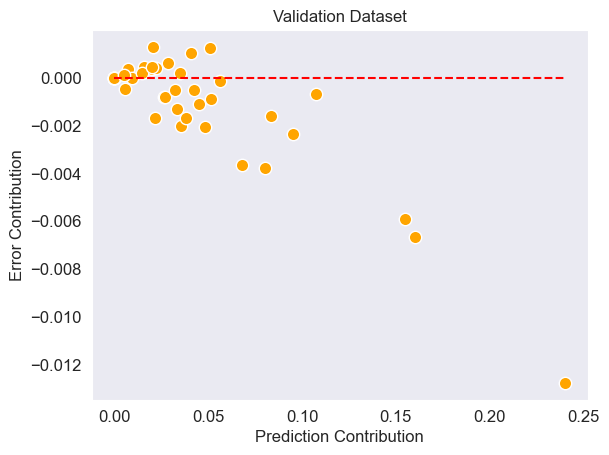

In [30]:
fig, ax = plt.subplots()

ax.scatter(contributions_val["prediction_contribution"], contributions_val["error_contribution"], s=80, color="orange", edgecolors="white")
ax.hlines(y=0, xmin=0, xmax=contributions_val["prediction_contribution"].max(), ls="--", color="red")
ax.tick_params(axis="both", which="major", labelsize=12)

ax.grid()
ax.set_axisbelow(True)
ax.set_title("Validation Dataset", fontsize=12)
ax.set_xlabel("Prediction Contribution", fontsize=12)
ax.set_ylabel("Error Contribution", fontsize=12)

fig.savefig("single_val.png", dpi=200, bbox_inches="tight")

In [31]:
pd.set_option("display.max_rows", 10)

contributions_val.sort_values("error_contribution", ascending=True).round(4).head(10)

,prediction_contribution,error_contribution
avg_home_team_rating,0.2401,-0.0128
avg_away_rating_attack,0.1600,-0.0067
ewm_shoton_home,0.1548,-0.0059
ewm_home_team_goals_conceded,0.0805,-0.0038
avg_home_rating_attack,0.0679,-0.0037
ewm_away_team_goals,0.0954,-0.0024
home_streak_wins,0.0486,-0.0021
player_rating_home_player_7,0.0358,-0.0020
ewm_possession_home,0.0216,-0.0017
home_weighted_wins,0.0381,-0.0017


In [32]:
from tqdm import tqdm
from sklearn.metrics import log_loss, average_precision_score

features = X_train.columns.to_list()
rfe_error = pd.DataFrame(dtype=float)
features_curr = features.copy()
feature_drop = None

for iteration in tqdm(range(len(features))):
    preds_val, shaps_val, shap_expected_value_val = get_preds_shaps(X_train[features_curr], X_val[features_curr], y_train, y_val, False)

    prediction_contribution_val, error_contribution_val = get_feature_contributions(
        y_true=y_val,
        y_pred=preds_val,
        shap_values=shaps_val,
        shap_expected_value=shap_expected_value_val
    )

    rfe_error.loc[iteration, "feature_drop"] = feature_drop
    rfe_error.loc[iteration, "n_features"] = len(features_curr)
    rfe_error.loc[iteration, "contrib"] = error_contribution_val.max()

    rfe_error.loc[iteration, "logloss_trn"] = log_loss(y_train['result_match'], preds_train)
    rfe_error.loc[iteration, "logloss_val"] = log_loss(y_val['result_match'], preds_val)
    # rfe_error.loc[iteration, "logloss_tst"] = log_loss(df.loc[ix_tst, target], preds.loc[ix_tst])

    rfe_error.loc[iteration, "ap_trn"] = average_precision_score(y_train['result_match'], preds_train, average='weighted')
    rfe_error.loc[iteration, "ap_val"] = average_precision_score(y_val['result_match'], preds_val, average='weighted')
    # rfe_error.loc[iteration, "ap_tst"] = average_precision_score(df.loc[ix_tst, target], preds.loc[ix_tst])

    # rfe_error.loc[iteration, "f1_trn"] = f1_score(y_train['result_match'], preds_train, average='binary', pos_label='binary')
    # rfe_error.loc[iteration, "f1_val"] = f1_score(y_val['result_match'], preds_val, average='binary', pos_label='binary')
    # rfe_error.loc[iteration, "f1_tst"] = f1_score(df.loc[ix_tst, target], preds.loc[ix_tst])

    feature_drop = error_contribution_val.idxmax()

    features_curr.remove(feature_drop)

100%|██████████| 47/47 [00:10<00:00,  4.42it/s]


In [33]:
features = X_train.columns.to_list()
rfe_prediction = pd.DataFrame(dtype=float)
features_curr = features.copy()
feature_drop = None

for iteration in tqdm(range(len(features))):
    preds_val, shaps_val, shap_expected_value_val = get_preds_shaps(X_train[features_curr], X_val[features_curr], y_train, y_val, False)

    prediction_contribution_val, error_contribution_val = get_feature_contributions(
        y_true=y_val,
        y_pred=preds_val,
        shap_values=shaps_val,
        shap_expected_value=shap_expected_value_val
    )

    rfe_prediction.loc[iteration, "feature_drop"] = feature_drop
    rfe_prediction.loc[iteration, "n_features"] = len(features_curr)
    rfe_prediction.loc[iteration, "contrib"] = prediction_contribution_val.max()

    rfe_prediction.loc[iteration, "logloss_trn"] = log_loss(y_train['result_match'], preds_train)
    rfe_prediction.loc[iteration, "logloss_val"] = log_loss(y_val['result_match'], preds_val)
    # rfe_prediction.loc[iteration, "logloss_tst"] = log_loss(df.loc[ix_tst, target], preds.loc[ix_tst])
    rfe_prediction.loc[iteration, "ap_trn"] = average_precision_score(y_train['result_match'], preds_train)
    rfe_prediction.loc[iteration, "ap_val"] = average_precision_score(y_val['result_match'], preds_val)
    # rfe_prediction.loc[iteration, "ap_tst"] = average_precision_score(df.loc[ix_tst, target], preds.loc[ix_tst])

    # rfe_prediction.loc[iteration, "f1_trn"] = f1_score(y_train['result_match'], preds_train, average='weighted'))
    # rfe_prediction.loc[iteration, "f1_val"] = f1_score(y_val['result_match'], preds_val, average='weighted'))
    # rfe_prediction.loc[iteration, "f1_tst"] = f1_score(df.loc[ix_tst, target], preds.loc[ix_tst])

    feature_drop = prediction_contribution_val.idxmax()

    features_curr.remove(feature_drop)

100%|██████████| 47/47 [00:10<00:00,  4.35it/s]


In [34]:
max_iter_show = len(features) - 5

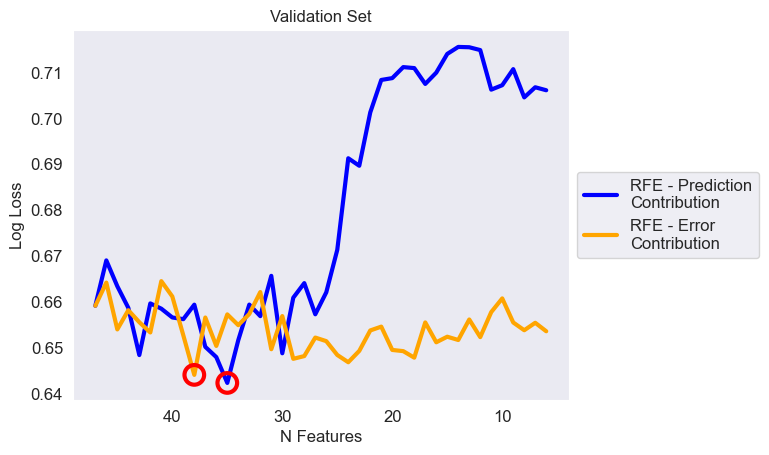

In [35]:
fig, ax = plt.subplots()

idxmin_prediction = rfe_prediction["logloss_val"].idxmin()
idxmin_error = rfe_error["logloss_val"].idxmin()

ax.plot(-rfe_prediction.head(max_iter_show)["n_features"], rfe_prediction.head(max_iter_show)["logloss_val"], lw=3, color="blue", label="RFE - Prediction\nContribution")
ax.plot(-rfe_error.head(max_iter_show)["n_features"], rfe_error.head(max_iter_show)["logloss_val"], lw=3, color="orange", label="RFE - Error\nContribution")
ax.scatter(-rfe_prediction.loc[idxmin_prediction, "n_features"], rfe_prediction.loc[idxmin_prediction, "logloss_val"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.scatter(-rfe_error.loc[idxmin_error, "n_features"], rfe_error.loc[idxmin_error, "logloss_val"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.set_title("Validation Set", fontsize=12)
ax.set_ylabel("Log Loss", fontsize=12)
ax.set_xlabel("N Features", fontsize=12)
ax.set_xticklabels([-int(x) for x in ax.get_xticks()])
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=12)

fig.savefig("rfe_logloss_val_.png", dpi=200, bbox_inches="tight")

In [36]:
rfe_error.sort_values("logloss_val", ascending=True).head(10)

,feature_drop,n_features,contrib,logloss_trn,logloss_val,ap_trn,ap_val
9,avg_away_team_rating,38.0,5.875738e-04,0.600017,0.644127,0.753057,0.681456
23,player_rating_home_player_10,24.0,2.872047e-04,0.600017,0.646880,0.753057,0.702035
18,ewm_home_team_goals,29.0,7.471534e-04,0.600017,0.647625,0.753057,0.697415
29,player_rating_away_player_6,18.0,4.879514e-04,0.600017,0.647876,0.753057,0.696635
19,player_rating_home_player_2,28.0,7.914051e-04,0.600017,0.648220,0.753057,0.690066
22,defensive_weakness_away,25.0,6.890596e-04,0.600017,0.648463,0.753057,0.682099
28,player_rating_away_player_5,19.0,2.728805e-09,0.600017,0.649296,0.753057,0.679250
24,player_rating_away_player_1,23.0,1.097879e-03,0.600017,0.649349,0.753057,0.687730
27,player_rating_home_player_5,20.0,-6.587264e-09,0.600017,0.649557,0.753057,0.689711
16,player_rating_away_player_10,31.0,5.318198e-04,0.600017,0.649711,0.753057,0.696223


In [37]:
X

,player_rating_home_player_1,player_rating_home_player_2,player_rating_home_player_3,player_rating_home_player_4,player_rating_home_player_5,player_rating_home_player_6,player_rating_home_player_7,player_rating_home_player_8,player_rating_home_player_9,player_rating_home_player_10,...,ewm_possession_away,avg_home_rating_attack,avg_away_rating_attack,avg_away_rating_defence,avg_home_rating_defence,average_rating_home,average_rating_away,avg_home_team_rating_x_ewm_shoton_away,defensive_weakness_home,defensive_weakness_away
0,72,72,72,72,72,72,79,75,85,87,...,NaN,78.50,71.50,71.0,72.0,75.545455,71.272727,NaN,NaN,NaN
1,79,79,79,79,79,79,78,75,74,81,...,NaN,75.83,82.33,84.0,79.0,77.272727,83.090909,NaN,NaN,NaN
2,77,77,77,77,77,77,72,82,76,73,...,NaN,76.33,73.50,76.0,77.0,76.636364,74.636364,NaN,NaN,NaN
3,82,82,82,82,82,82,72,73,77,73,...,NaN,76.33,77.50,73.0,82.0,78.909091,75.454545,NaN,NaN,NaN
4,77,77,77,77,77,77,67,75,82,84,...,NaN,77.00,79.33,84.0,77.0,77.000000,81.454545,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,80,80,80,80,80,80,79,75,80,51,...,52.130,74.50,73.33,74.0,80.0,77.000000,73.636364,36.005200,3.012987,2.091358
3036,86,86,86,86,86,86,83,83,83,88,...,52.362,82.83,75.50,76.0,86.0,84.272727,75.727273,43.213656,2.017260,1.003601
3037,79,79,79,79,79,79,81,86,88,85,...,52.919,83.50,74.67,76.0,79.0,81.454545,75.272727,38.867940,1.129464,2.550725
3038,78,78,78,78,78,78,76,80,79,75,...,45.764,77.33,78.83,76.0,78.0,77.636364,77.545455,61.459824,1.017564,1.650645


In [38]:
# Initialize results DataFrame without the dataset_name
results = pd.DataFrame(columns=["feature_set", "len_set", "preds_corr_bs", "ap_from_shaps_bs", "ap_from_model_bs", "roc_from_shaps_bs", "roc_from_model_bs"])

feature_sets = []

# Generate random feature sets
for enum in range(50):
    row_id = "_" + str(enum+1).zfill(2)  # Simplified row_id, as we don't use dataset_name anymore
    while True:
        feature_set = sorted(np.random.choice(X_train.columns, replace=False, size=np.random.randint(1, len(X_train.columns))))
        if feature_set not in feature_sets:
            feature_sets.append(feature_set)
            results.loc[row_id, :] = feature_set, len(feature_set), [], [], [], [], []
            break

for bootstrap_iter in range(5):
    # Get predictions, SHAP values, and SHAP expected value
    preds, shaps, shaps_ev = get_preds_shaps(X_train, X_val, y_train, y_val, False)

    # Save results of the full model using a fixed identifier for the full feature set row
    full_model_row_id = "_00"
    if full_model_row_id not in results.index:
        results.loc[full_model_row_id, :] = sorted(X_train.columns), len(X_train.columns), [], [], [], [], []
    results.at[full_model_row_id, "ap_from_shaps_bs"].append(average_precision_score(y_val, preds))
    results.at[full_model_row_id, "ap_from_model_bs"].append(average_precision_score(y_val, preds))
    results.at[full_model_row_id, "roc_from_shaps_bs"].append(roc_auc_score(y_val, preds))
    results.at[full_model_row_id, "roc_from_model_bs"].append(roc_auc_score(y_val, preds))

    for enum, feature_set in enumerate(feature_sets):
        row_id = "_" + str(enum+1).zfill(2)

        # Compute predictions as estimated from the SHAP values
        preds_from_shaps = shap_sum2proba(shap_sum=shaps_ev + shaps[feature_set].sum(axis=1))

        # Get predictions from model trained on the feature set
        preds_from_model = pd.Series(
            XGBClassifier(**space, random_state=42, enable_categorical=True, scale_pos_weight=2).fit(X_train[feature_set], y_train).predict_proba(X_val[feature_set])[:, 1],
            index=X_val.index
        )

        results.at[row_id, "preds_corr_bs"].append(preds_from_shaps.corr(preds_from_model))
        results.at[row_id, "ap_from_shaps_bs"].append(average_precision_score(y_val, preds_from_shaps))
        results.at[row_id, "ap_from_model_bs"].append(average_precision_score(y_val, preds_from_model))
        results.at[row_id, "roc_from_shaps_bs"].append(roc_auc_score(y_val, preds_from_shaps))
        results.at[row_id, "roc_from_model_bs"].append(roc_auc_score(y_val, preds_from_model))

# Calculate mean values for bootstrap results
results["preds_corr"] = results["preds_corr_bs"].apply(np.mean)
results["ap_from_shaps"] = results["ap_from_shaps_bs"].apply(np.mean)
results["ap_from_model"] = results["ap_from_model_bs"].apply(np.mean)
results["roc_from_shaps"] = results["roc_from_shaps_bs"].apply(np.mean)
results["roc_from_model"] = results["roc_from_model_bs"].apply(np.mean)

In [39]:
results

,feature_set,len_set,preds_corr_bs,ap_from_shaps_bs,ap_from_model_bs,roc_from_shaps_bs,roc_from_model_bs,preds_corr,ap_from_shaps,ap_from_model,roc_from_shaps,roc_from_model
_01,"[average_rating_away, avg_away_rating_attack, ...",41,"[0.8132599454933918, 0.8132599454933918, 0.813...","[0.6555807863454047, 0.6555807863454047, 0.655...","[0.66185777079906, 0.66185777079906, 0.6618577...","[0.7064639197732723, 0.7064639197732723, 0.706...","[0.6879114889906257, 0.6879114889906257, 0.687...",0.813260,0.655581,0.661858,0.706464,0.687911
_02,"[average_rating_home, avg_home_rating_defence,...",16,"[0.662136770288328, 0.662136770288328, 0.66213...","[0.6467902223488984, 0.6467902223488984, 0.646...","[0.6520677019546817, 0.6520677019546817, 0.652...","[0.6556463919773273, 0.6556463919773273, 0.655...","[0.6945825158055374, 0.6945825158055374, 0.694...",0.662137,0.646790,0.652068,0.655646,0.694583
_03,"[avg_away_rating_defence, avg_home_rating_defe...",11,"[0.5076301412355362, 0.5076301412355362, 0.507...","[0.5018064149619877, 0.5018064149619877, 0.501...","[0.6674571077580461, 0.6674571077580461, 0.667...","[0.5957052539786353, 0.5957052539786353, 0.595...","[0.7143666884674079, 0.7143666884674079, 0.714...",0.507630,0.501806,0.667457,0.595705,0.714367
_04,"[away_streak_wins, defensive_weakness_away, de...",12,"[0.6946780422131549, 0.6946780422131549, 0.694...","[0.5862414870097141, 0.5862414870097141, 0.586...","[0.6452867624451142, 0.6452867624451142, 0.645...","[0.6492805755395683, 0.6492805755395683, 0.649...","[0.6921626335295401, 0.6921626335295401, 0.692...",0.694678,0.586241,0.645287,0.649281,0.692163
_05,"[average_rating_home, avg_away_team_rating, de...",7,"[0.5187573240943649, 0.5187573240943649, 0.518...","[0.50574929675973, 0.50574929675973, 0.5057492...","[0.6586041223015635, 0.6586041223015635, 0.658...","[0.6003052103771528, 0.6003052103771528, 0.600...","[0.7009265315020711, 0.7009265315020711, 0.700...",0.518757,0.505749,0.658604,0.600305,0.700927
...,...,...,...,...,...,...,...,...,...,...,...,...
_47,"[avg_away_rating_defence, avg_home_rating_defe...",21,"[0.7639783235201548, 0.7639783235201548, 0.763...","[0.6506621026304193, 0.6506621026304193, 0.650...","[0.6373227956358181, 0.6373227956358181, 0.637...","[0.7001090037061259, 0.7001090037061259, 0.700...","[0.6755395683453238, 0.6755395683453238, 0.675...",0.763978,0.650662,0.637323,0.700109,0.675540
_48,"[average_rating_away, average_rating_home, avg...",38,"[0.7845498350773988, 0.7845498350773988, 0.784...","[0.666729636395199, 0.666729636395199, 0.66672...","[0.6628339502766842, 0.6628339502766842, 0.662...","[0.7143993895792456, 0.7143993895792456, 0.714...","[0.6832025288859821, 0.6832025288859821, 0.683...",0.784550,0.666730,0.662834,0.714399,0.683203
_49,"[average_rating_away, average_rating_home, avg...",40,"[0.7890162925401236, 0.7890162925401236, 0.789...","[0.6663313375936996, 0.6663313375936996, 0.666...","[0.6806568355748043, 0.6806568355748043, 0.680...","[0.7087202964900806, 0.7087202964900806, 0.708...","[0.6963156747329409, 0.6963156747329409, 0.696...",0.789016,0.666331,0.680657,0.708720,0.696316
_50,"[average_rating_away, average_rating_home, avg...",34,"[0.8199404420780628, 0.8199404420780628, 0.819...","[0.6742900131352967, 0.6742900131352967, 0.674...","[0.6291959925899621, 0.6291959925899621, 0.629...","[0.709614126880314, 0.709614126880314, 0.70961...","[0.6755177676040987, 0.6755177676040987, 0.675...",0.819940,0.674290,0.629196,0.709614,0.675518


In [40]:
# Calculate Spearman correlation between 'ap_from_shaps' and 'ap_from_model'
spearman_corr = results["ap_from_shaps"].corr(results["ap_from_model"], method="spearman")

# Format the correlation as a percentage and round to the nearest whole number
formatted_corr = f"{int(round(spearman_corr * 100, 0))}%"

print(formatted_corr)

36%


In [41]:
results['feature_set'][0]

['average_rating_away',
 'avg_away_rating_attack',
 'avg_away_rating_defence',
 'avg_away_team_rating',
 'avg_home_rating_defence',
 'avg_home_team_rating',
 'avg_home_team_rating_x_ewm_shoton_away',
 'away_streak_wins',
 'away_weighted_wins',
 'defensive_weakness_away',
 'ewm_away_team_goals',
 'ewm_away_team_goals_conceded',
 'ewm_home_team_goals',
 'ewm_home_team_goals_conceded',
 'ewm_possession_away',
 'ewm_possession_home',
 'ewm_shoton_away',
 'ewm_shoton_home',
 'home_streak_wins',
 'home_weighted_wins',
 'player_rating_away_player_1',
 'player_rating_away_player_10',
 'player_rating_away_player_11',
 'player_rating_away_player_2',
 'player_rating_away_player_3',
 'player_rating_away_player_4',
 'player_rating_away_player_5',
 'player_rating_away_player_6',
 'player_rating_away_player_7',
 'player_rating_away_player_8',
 'player_rating_home_player_1',
 'player_rating_home_player_10',
 'player_rating_home_player_11',
 'player_rating_home_player_2',
 'player_rating_home_player_3'

In [42]:
# Add columns for accuracy and roc_auc metrics
results['f1'] = None

for index, row in results.iterrows():
    feature_set = row['feature_set']
    f1, model = evaluate_model_opt(X_train[feature_set], X_val[feature_set], y_train, y_val, space)
    
    # Update the results DataFrame with the performance metrics
    results.at[index, 'f1'] = f1


In [43]:
results[['feature_set', 'f1']]

,feature_set,f1
_01,"[average_rating_away, avg_away_rating_attack, ...",0.643678
_02,"[average_rating_home, avg_home_rating_defence,...",0.662011
_03,"[avg_away_rating_defence, avg_home_rating_defe...",0.660993
_04,"[away_streak_wins, defensive_weakness_away, de...",0.668588
_05,"[average_rating_home, avg_away_team_rating, de...",0.670285
...,...,...
_47,"[avg_away_rating_defence, avg_home_rating_defe...",0.669516
_48,"[average_rating_away, average_rating_home, avg...",0.656115
_49,"[average_rating_away, average_rating_home, avg...",0.649624
_50,"[average_rating_away, average_rating_home, avg...",0.662873


In [44]:
results

,feature_set,len_set,preds_corr_bs,ap_from_shaps_bs,ap_from_model_bs,roc_from_shaps_bs,roc_from_model_bs,preds_corr,ap_from_shaps,ap_from_model,roc_from_shaps,roc_from_model,f1
_01,"[average_rating_away, avg_away_rating_attack, ...",41,"[0.8132599454933918, 0.8132599454933918, 0.813...","[0.6555807863454047, 0.6555807863454047, 0.655...","[0.66185777079906, 0.66185777079906, 0.6618577...","[0.7064639197732723, 0.7064639197732723, 0.706...","[0.6879114889906257, 0.6879114889906257, 0.687...",0.813260,0.655581,0.661858,0.706464,0.687911,0.643678
_02,"[average_rating_home, avg_home_rating_defence,...",16,"[0.662136770288328, 0.662136770288328, 0.66213...","[0.6467902223488984, 0.6467902223488984, 0.646...","[0.6520677019546817, 0.6520677019546817, 0.652...","[0.6556463919773273, 0.6556463919773273, 0.655...","[0.6945825158055374, 0.6945825158055374, 0.694...",0.662137,0.646790,0.652068,0.655646,0.694583,0.662011
_03,"[avg_away_rating_defence, avg_home_rating_defe...",11,"[0.5076301412355362, 0.5076301412355362, 0.507...","[0.5018064149619877, 0.5018064149619877, 0.501...","[0.6674571077580461, 0.6674571077580461, 0.667...","[0.5957052539786353, 0.5957052539786353, 0.595...","[0.7143666884674079, 0.7143666884674079, 0.714...",0.507630,0.501806,0.667457,0.595705,0.714367,0.660993
_04,"[away_streak_wins, defensive_weakness_away, de...",12,"[0.6946780422131549, 0.6946780422131549, 0.694...","[0.5862414870097141, 0.5862414870097141, 0.586...","[0.6452867624451142, 0.6452867624451142, 0.645...","[0.6492805755395683, 0.6492805755395683, 0.649...","[0.6921626335295401, 0.6921626335295401, 0.692...",0.694678,0.586241,0.645287,0.649281,0.692163,0.668588
_05,"[average_rating_home, avg_away_team_rating, de...",7,"[0.5187573240943649, 0.5187573240943649, 0.518...","[0.50574929675973, 0.50574929675973, 0.5057492...","[0.6586041223015635, 0.6586041223015635, 0.658...","[0.6003052103771528, 0.6003052103771528, 0.600...","[0.7009265315020711, 0.7009265315020711, 0.700...",0.518757,0.505749,0.658604,0.600305,0.700927,0.670285
...,...,...,...,...,...,...,...,...,...,...,...,...,...
_47,"[avg_away_rating_defence, avg_home_rating_defe...",21,"[0.7639783235201548, 0.7639783235201548, 0.763...","[0.6506621026304193, 0.6506621026304193, 0.650...","[0.6373227956358181, 0.6373227956358181, 0.637...","[0.7001090037061259, 0.7001090037061259, 0.700...","[0.6755395683453238, 0.6755395683453238, 0.675...",0.763978,0.650662,0.637323,0.700109,0.675540,0.669516
_48,"[average_rating_away, average_rating_home, avg...",38,"[0.7845498350773988, 0.7845498350773988, 0.784...","[0.666729636395199, 0.666729636395199, 0.66672...","[0.6628339502766842, 0.6628339502766842, 0.662...","[0.7143993895792456, 0.7143993895792456, 0.714...","[0.6832025288859821, 0.6832025288859821, 0.683...",0.784550,0.666730,0.662834,0.714399,0.683203,0.656115
_49,"[average_rating_away, average_rating_home, avg...",40,"[0.7890162925401236, 0.7890162925401236, 0.789...","[0.6663313375936996, 0.6663313375936996, 0.666...","[0.6806568355748043, 0.6806568355748043, 0.680...","[0.7087202964900806, 0.7087202964900806, 0.708...","[0.6963156747329409, 0.6963156747329409, 0.696...",0.789016,0.666331,0.680657,0.708720,0.696316,0.649624
_50,"[average_rating_away, average_rating_home, avg...",34,"[0.8199404420780628, 0.8199404420780628, 0.819...","[0.6742900131352967, 0.6742900131352967, 0.674...","[0.6291959925899621, 0.6291959925899621, 0.629...","[0.709614126880314, 0.709614126880314, 0.70961...","[0.6755177676040987, 0.6755177676040987, 0.675...",0.819940,0.674290,0.629196,0.709614,0.675518,0.662873


In [54]:
import os

# Define the directory path
dir_path = "../feature_selection"

# Convert the list to a DataFrame
best_feature_set_df = pd.DataFrame(best_feature_set_row, columns=['Best Feature Set'])

# Define the directory path
dir_path = "../feature_selection"
file_name = "best_feature_set_results.csv"

# Ensure the directory exists
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

# Save the DataFrame to a CSV file
best_feature_set_df.to_csv(os.path.join(dir_path, file_name), sep="\t", index=False)

In [55]:
best_feature_set_df

,Best Feature Set
0,average_rating_away
1,average_rating_home
2,avg_away_rating_attack
3,avg_away_rating_defence
4,avg_away_team_rating
...,...
35,player_rating_home_player_7
36,player_rating_home_player_8
37,player_rating_home_player_9
38,points_away


In [52]:
results.loc[results['f1'].idxmax()]['feature_set']

['average_rating_away',
 'average_rating_home',
 'avg_away_rating_attack',
 'avg_away_rating_defence',
 'avg_away_team_rating',
 'avg_home_rating_attack',
 'avg_home_rating_defence',
 'avg_home_team_rating',
 'avg_home_team_rating_x_ewm_shoton_away',
 'away_streak_wins',
 'away_weighted_wins',
 'defensive_weakness_away',
 'ewm_away_team_goals',
 'ewm_home_team_goals',
 'ewm_home_team_goals_conceded',
 'ewm_possession_away',
 'ewm_possession_home',
 'ewm_shoton_away',
 'home_streak_wins',
 'home_weighted_wins',
 'player_rating_away_player_1',
 'player_rating_away_player_10',
 'player_rating_away_player_2',
 'player_rating_away_player_3',
 'player_rating_away_player_4',
 'player_rating_away_player_5',
 'player_rating_away_player_6',
 'player_rating_away_player_9',
 'player_rating_home_player_1',
 'player_rating_home_player_10',
 'player_rating_home_player_11',
 'player_rating_home_player_2',
 'player_rating_home_player_3',
 'player_rating_home_player_4',
 'player_rating_home_player_6',
 

In [ ]:
# https://towardsdatascience.com/approximate-predictions-make-feature-selection-radically-faster-0f9664877687 - Approximate-Predictions

# https://towardsdatascience.com/which-features-are-harmful-for-your-classification-model-6227859a44a6 - error/prediction contribution